In [1]:
import h5py

import numpy as np

from matplotlib import pyplot as plt
import pickle
import copy
from get_data import get_data
%matplotlib inline

Label Indices:
'ibd_prompt':1,
'ibd_delay':2,
'muon':3,
'flasher':4,
'other':5

In [2]:
label_keys =  {'ibd_prompt':1, 'ibd_delay':2, 'muon':3, 'flasher':4, 'other':5}

In [3]:
rev_label_keys = {v:k for k,v in label_keys.iteritems()}

# Getting the Data

Ok, let's get our data here. Note we have a nice little black box function that returns two arrays:
* raw data, 
    * an array of the charge values of PMT's for 2500 events (2500,8,24)
* labels
    * the event type

In [4]:
raw_data, labels = get_data(num_each=500)

Let's check the shapes here and make sure we are on track

In [5]:
print raw_data.shape, labels.shape

(2500, 8, 24) (2500,)


Let's look at some sample images for each class.
Remember our event types are:
* IBD prompt 
* IBD Delay
* Muon
* Flasher
* Other

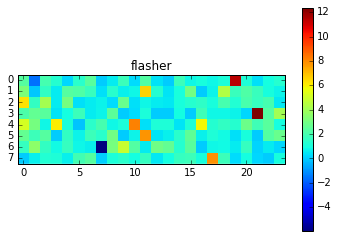

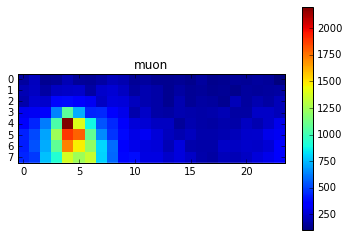

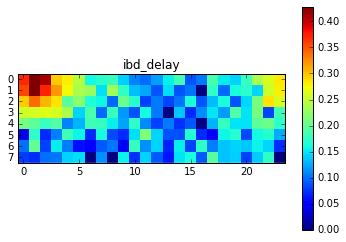

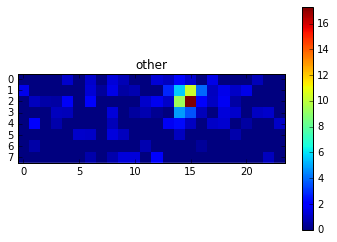

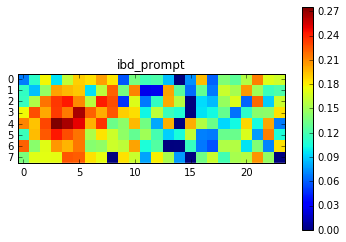

In [6]:
ibd_prompt_ex,\
ibd_delay_ex, \
muon_ex, \
flasher_ex, other_ex  =[ raw_data[labels==label_keys[name]][0] for name in ['ibd_prompt', 'ibd_delay', 'muon', 'flasher', 'other']]

for i, event_type in enumerate(label_keys.keys()):
    plt.figure(i)
    plt.title(event_type)
    plt.imshow(raw_data[labels==label_keys[event_type]][17], interpolation='none')
    plt.colorbar()

You may notice the order of magnitude differences may make it easy to discern the different event types, but this exercise is more of a proof of concept of whether we can encode the different event types in a low dimensional space and visualize them

# Preprocessing

As we can see by the color bar, the muons are a few orders of magnitude higher than the ibd's, 
so it make sense to do some preporcessing here and take the log of the charges, so the training is not too overly influenced by muons.
Additionally we will scale the data between -1 and 1 so as not to cause dramatic swings in the update of the weights

### Split into train and validation

First, let's split into train and validation, so test does not influence the training set preprocessing. Usually we want an 80-20 split

In [51]:
last_ind = int(0.8 * raw_data.shape[0])
raw_tr, lbl_tr, raw_val, lbl_val = raw_data[:last_ind], labels[:last_ind], raw_data[last_ind:], labels[last_ind:]

### Log Transform
We apply a log transform here to counteract the muons and flashers being orders of magnitude higher

In [52]:
preproc_tr = copy.deepcopy(raw_tr)
preproc_val = copy.deepcopy(raw_val)
#take the log
# we add a small value to the argument of the log to avoid taking the log of 0
preproc_tr = np.log(np.abs(preproc_tr) +0.0001)
preproc_val = np.log(np.abs(preproc_val) +0.0001)

### Scaling
We also scale between -1 and 1, which is another common preprocessing technique.
Note that we only calculate the global max and min of the training data and then use those to preprocess the test and train

In [53]:
# scale between -1 and 1
#(we use the training data to get the min and max statistics and then we apply that to the test data)
min_ = preproc_tr.min()
max_ = preproc_tr.max()
range_ = max_ - min_
x_tr = 2 * ((preproc_tr - min_) / range_) - 1
x_val = 2 * ((preproc_val - min_) / range_) - 1



Let's check whether we scaled correctly

In [10]:
print x_tr.max()
print x_tr.min()

1.0
-1.0


In [54]:
print x_val.max()
print x_val.min()

0.988241207032
-1.0


One last thing: the network expects 4 dimensions (number of events by number of channels by x by y), so we need to add a dimension for number of channels, which is one in this case

In [59]:
x_tr = np.expand_dims(x_tr, axis=1)

x_val = np.expand_dims(x_val,axis=1)

x_tr.shape

(2000, 1, 8, 24)

# Building the Network
Ok we have our data. Now let's build our convolutional autoencoder!



We'll use Keras here, which is one of the best deep learning frameworks for getting something prototyped up quickly. It's backend is either Theano or Tensorflow. We will use the Theano backend for today

In [13]:
import keras

Using Theano backend.


In [45]:
from keras.layers import Convolution2D, Input, Dense, Deconvolution2D,  GaussianNoise,\
ZeroPadding2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

from keras.models import Model
from keras.optimizers import SGD

from keras.objectives import mean_squared_error
from theano import tensor as T

Let's set of few parameters here:
* __Number of filters__
    * this is the number of convultional filters applied to the set of ferature maps at each layer
* __Code size__
    * this is the length of the vector that we encode each image into
* __Batch size__
    * this is the number of images we process before each weight update

In [15]:
num_filters = 128
code_size = 1024
batch_size = 50

Ok let's specify the layers of our network

In [16]:
# output of this layer is 1,8,24
input_event = Input(shape=(1,8,24))

layer_kwargs = {'init':'he_normal', 'activation':'relu'}

Note we use a __denosing autoencoder__ here. By adding noise to the input, but still forcing the network to reconstruct the uncorrupted input, we are able to prevent the network from just copying the input (indentity function), but also we allow it to "fill in the blanks" and learn the important patterns

Here, we construct each layer and apply it to the previous layer. As we make our network, Keras is building a symbolic computation graph, which will be compiled to a C executable.

Here is the encoder

In [17]:
net = GaussianNoise(0.01)(input_event)
# output of this layer is num_filters,11,12
net = Convolution2D(num_filters,2,2,subsample=(1,2), **layer_kwargs)(ZeroPadding2D(padding=(2,0))(input_event))
nett=net
#output of this layer is num_filters, 6, 6
net = Convolution2D(num_filters,2,2,subsample=(2,2), **layer_kwargs)(ZeroPadding2D(padding=(1,0))(net))

#out put of this layer is num_filters, 3, 3
net = MaxPooling2D((2,2))(net)

#output is num_filters*3*3
net = Flatten()(net)

#output is code_size
code = Dense(output_dim=code_size, **layer_kwargs)(net)

encoder = Model(input=input_event, output=code)

And the decoder

In [18]:
#output is num_filters*3*3
net = Dense(output_dim=num_filters*3*3)(code)

#output is num_filters, 3, 3
net = Reshape((num_filters,3,3))(net)

#output is num_filters, 6, 6
net = UpSampling2D((2,2))(net)

#output is num_filters, 8, 12
net=Deconvolution2D(num_filters,3,2,(batch_size,num_filters,8,12), subsample=(1,2), **layer_kwargs)(net)

#output is num_filters, 8, 24
output = Deconvolution2D(1,1,2,(batch_size,1,8,24), subsample=(1,2),activation='linear')(net)

Now, we construct our model, set the learning rate and optimization and compile it.

In [22]:
m=Model(input=input_event,output=output)

sgd = SGD(lr=0.1, decay=0, momentum=0.9, nesterov=True)

m.compile(optimizer=sgd,loss=mean_squared_error)

Let's make a little class here that will plot the learning curve to help us see our learning progress

In [20]:
class PlotLearnCurve(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        plt.clf()
        self.losses = []
    
    def on_batch_begin(self, batch, logs={}):
        self.size = logs['size']

    def on_batch_end(self, batch, logs={}):
        self.batch_loss += logs.get('loss')
        
    def on_epoch_begin(self,epoch,logs={}):
        self.batch_loss = 0
    def on_epoch_end(self,epoch,logs={}):
        self.losses.append(self.batch_loss / self.size)
        plt.plot(self.losses)

Now let's train this thing'

Train on 2000 samples, validate on 500 samples
Epoch 1/10
2000/2000 [==============================] - 5s - loss: 0.0436 - val_loss: 0.0468
Epoch 2/10
2000/2000 [==============================] - 5s - loss: 0.0430 - val_loss: 0.0459
Epoch 3/10
2000/2000 [==============================] - 5s - loss: 0.0420 - val_loss: 0.0455
Epoch 4/10
2000/2000 [==============================] - 5s - loss: 0.0416 - val_loss: 0.0457
Epoch 5/10
2000/2000 [==============================] - 5s - loss: 0.0415 - val_loss: 0.0457
Epoch 6/10
2000/2000 [==============================] - 5s - loss: 0.0406 - val_loss: 0.0451
Epoch 7/10
2000/2000 [==============================] - 5s - loss: 0.0399 - val_loss: 0.0444
Epoch 8/10
2000/2000 [==============================] - 5s - loss: 0.0396 - val_loss: 0.0445
Epoch 9/10
2000/2000 [==============================] - 5s - loss: 0.0392 - val_loss: 0.0440
Epoch 10/10
2000/2000 [==============================] - 5s - loss: 0.0391 - val_loss: 0.0441


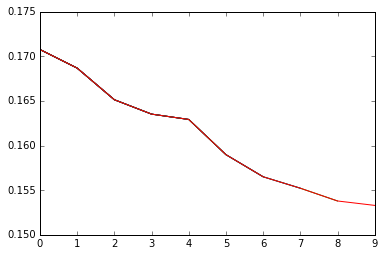

In [60]:
m.fit(x_tr,x_tr,callbacks=[PlotLearnCurve()],validation_data=(x_val,x_val), nb_epoch=10)

In [24]:
rec_tr=m.predict(x_tr)

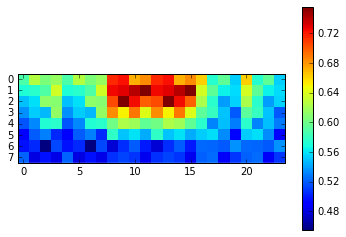

In [25]:

plt.imshow(rec_tr[11,0],interpolation='none')
plt.colorbar()

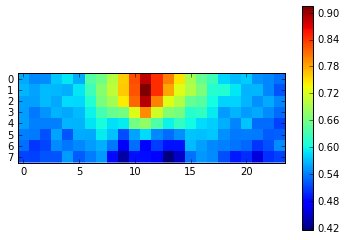

In [26]:
plt.imshow(x_tr[11][0], interpolation='none')
plt.colorbar()

In [27]:
from sklearn.manifold import TSNE

Let's extract the feature vector for each example

In [29]:
code_tr=encoder.predict(x_tr)

In [30]:
code_tr.shape

(2000, 1024)

TSNE is a dimensionality technique for visualization that maps data points that are close together in high-dimensional space to be close together in low-dimensional space. 
There are two ways to go:
* small feature vector
* large feature vector + TSNE
 * allows you to capture complexties of the data that allow for potentially better training, yet you can still view the data points in low dimensions

In [31]:
tsne = TSNE()

In [32]:
tr_tsn= tsne.fit_transform(code_tr[:1000])

In [33]:
pickle.dump((x_tr[:1000], tr_tsn[:1000], lbl_tr[:1000],rev_label_keys), open('tsne.pkl', 'w'))